In [ ]:
import pickle
import shapely
from pathlib import Path
import pandas as pd
import xarray as xr
import rioxarray as rxa

# Add main repo to path
import sys
from os.path import expanduser
sys.path.append(expanduser('../../'))

from spicy_snow import retrieve_snow_depth

from spicy_snow.IO.user_dates import get_input_dates
from spicy_snow.processing.s1_preprocessing import merge_partial_s1_images
from spicy_snow.download.sentinel1 import combine_s1_images

In [2]:
from shapely import geometry
from pathlib import Path
from itertools import product
for lon_min, lat_min in product(range(-117, -113), range(43, 46)):
    print(Path(f'~/scratch/spicy-lowman-quadrant/spicy-lowman_{lon_min}-{lon_min + 1}_{lat_min}-{lat_min + 1}.nc').expanduser())
    # area = geometry.box(-117, 43, -113, 46)

/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-117--116_43-44.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-117--116_44-45.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-117--116_45-46.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-116--115_43-44.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-116--115_44-45.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-116--115_45-46.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-115--114_43-44.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-115--114_44-45.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-115--114_45-46.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-114--113_43-44.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-114--113_44-45.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowm

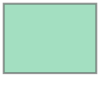

In [3]:
area

In [ ]:
ds = xr.open_dataset(Path('~/Desktop/spicy-lowman.nc').expanduser())

In [ ]:
area = shapely.geometry.box(-117, 43, -113, 46)

# results dictionary to send to next step
dataArrays = {}

for i, fp in enumerate(sorted(Path('~/Desktop/imgs').expanduser().glob('*VV.tif'))):
    if i < 6:
        urls = {}
        granule = fp.stem.replace('_VV', '')
        if i == 0:
            first_granule = granule
        urls[fp.stem] = fp
        urls[fp.stem.replace('VV', 'VH')] = str(fp.parents[0]) + '/' + fp.name.replace('VV', 'VH')
        urls[fp.stem.replace('VV', 'inc')] = str(fp.parents[0]) + '/' + fp.name.replace('VV', 'inc')
        imgs = []
        for name, url in urls.items():
            # download url to a tif file
            # url_download(url, join(outdir, f'{name}.tif'), verbose = False)

            # open image in xarray
            img = rxa.open_rasterio(url, masked = True)

            # reproject to WGS84
            img = img.rio.reproject('EPSG:4326')

            # clip to user specified area
            img = img.rio.clip_box(*area.bounds)

            # pad to area
            img = img.rio.pad_box(*area.bounds)

            # create band name
            band_name = name.replace(f'{granule}_', '')

            # add band to image
            img = img.assign_coords(band = [band_name])

            # coarsen image
            img = img.coarsen(x = 3, boundary = 'trim').mean().coarsen(y = 3, boundary = 'trim').mean()

            # add named band image to 3 image stack
            imgs.append(img)

        # concat VV, VH, and inc into one xarray DataArray
        da = xr.concat(imgs, dim = 'band')

        # we need to reproject each image to match the first image to make CRSs work
        if dataArrays:
            da = da.rio.reproject_match(dataArrays[first_granule])

        # add img to downloaded dataArrays list with granule as key
        dataArrays[granule] = da

In [ ]:
ds2 = combine_s1_images(dataArrays)